In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
import random

In [ ]:
RANDOM_STATE = 35

In [ ]:
df = pd.read_csv('train.csv', delimiter=',')

In [ ]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [ ]:
# Selects dataframe : df.select_dtypes(include=[int, object])

In [ ]:
# Check for missing values
print(f'missing data: {df.isnull().sum()}')

missing data: id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64


In [ ]:
df['price']=df['price'].astype('float')
df['price'].dtype

dtype('float64')

In [ ]:
def df_missing_cat(df):
    df['milage'] = df['milage'].astype('float')
    categorical_attributes = df.select_dtypes(include=[int, object]).columns.tolist()
    print(f'categorical attributes: {categorical_attributes}')

    categorical_data_missing = [attr for attr in categorical_attributes if df[attr].isnull().any()]
    print(f'Missing categories: {categorical_data_missing}')

    # Impute categorical features with mode
    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_data_missing] = mode_imputer.fit_transform(df[categorical_data_missing])

    return df

In [ ]:
df = df_missing_cat(df)

categorical attributes: ['id', 'brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Missing categories: ['fuel_type', 'accident', 'clean_title']


In [ ]:
# Categorical: Int, object: Won't scaled, applied mode Imputer
# Continuos: Float, float64:  Scaled, applied mean Imputer

In [ ]:
# Categorical
def get_automatic(string):
    string = string.lower()
    if 'a/t' in string or 'automatic' in string or 'at' in string:
        return 1
    else:
        return 0

In [ ]:
# Categorical
def get_gears(string):
    match = re.search(r'^(\d+)-Speed', string, re.IGNORECASE)
    if match:
        gears = match.group(1)
        return int(gears)
    else:
        return None

In [ ]:
# Contiunuos
def get_hp(engine):
    match = re.search(r'([\d.]+)HP', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [ ]:
# Continuos
def get_L(engine):
    match = re.search(r'([\d.]+)L', engine, re.IGNORECASE)
    if match:
      return float(match.group(1))
    else:
      return None

In [ ]:
# Categorical
def get_cyl(engine):
    match = re.search(r'([\d.]+)?\s?(?:Cylinder|Cyl|Cylinders)', engine, re.IGNORECASE)
    if match:
      return int(match.group(1))
    else:
      return None

In [ ]:
# Categorical
def is_electric(engine):
    if 'electric' in engine.lower():
      return 1
    else:
      return 0

In [ ]:
# Continuos
def num_valves(engine):
    match = re.search(r'([\d+])V', engine)
    if match:
      return float(match.group(1))
    else:
      return None

In [ ]:
# Categorical
def is_accident(accident):
    if type(accident) == str:
        if 'accident' in accident.lower():
          return 1
        else:
          return 0
    else:
        return None

In [ ]:
# Create ratios
def create_features(df):
    df['automatic'] = df['transmission'].apply(get_automatic)
    df['gears'] = df['transmission'].apply(get_gears)
    df['hp'] = df['engine'].apply(get_hp)
    df['L'] = df['engine'].apply(get_L)
    df['cylinders'] = df['engine'].apply(get_cyl)
    df['accident'] = df['accident'].apply(is_accident)
    df['electric'] = df['engine'].apply(is_electric)
    df['valves'] = df['engine'].apply(num_valves)
    return df

def create_interactions(df):
    df['hp/l'] = np.where(df['L'] != 0, df['hp'] / df['L'], None).astype('float')
    df['mil/l'] = np.where(df['L'] != 0, df['milage'] / df['L'], None).astype('float')
    df['mil/hp'] = np.where(df['hp'] != 0, df['milage'] / df['hp'], None).astype('float')
    df['l/cyl'] = np.where(df['cylinders'] != 0, df['L'] / df['cylinders'], None).astype('float')
    df['hp/gears'] = np.where(df['gears'] != 0, df['hp'] / df['gears'], None).astype('float')
    df['mil/gears'] = np.where(df['gears'] != 0, df['milage'] / df['gears'], None).astype('float')
    df['mil/cyl'] = np.where(df['cylinders'] != 0, df['milage'] / df['cylinders'], None).astype('float')

    df['hp*automatic'] = df['hp'] * df['automatic']
    df['cyl*gears'] = df['cylinders'] * df['gears']

    df['carAge'] = df['model_year'] - 2024
    df['mil/year'] = np.where(df['carAge'] != 0, df['milage'] / df['carAge'], None).astype('float')
    df['hp*accident'] = df['hp'] * df['accident']
    df['accident*carAge'] = df['accident'] * df['carAge']
    df['acc*milage'] = df['accident'] * df['milage']

    df['mil*carAge'] = df['milage'] * df['carAge']
    df['hp*mil'] = df['hp'] * df['milage']
    return df

In [ ]:
df = create_features(df)

In [ ]:
new_categoricals = list(df.select_dtypes(include=[int, object]).columns)
new_categoricals.extend(['L', 'cylinders', 'gears'])
new_categoricals

['id',
 'brand',
 'model',
 'model_year',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'automatic',
 'electric',
 'L',
 'cylinders',
 'gears']

In [ ]:
new_categoricals.remove('id')

### Missing values of new categoricals

In [ ]:
print(df.isnull().sum())

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears            84434
hp               33259
L                14214
cylinders        37855
electric             0
valves          165115
dtype: int64


In [ ]:
def df_missing_new_cat(df, new_categoricals):
    categorical_features_missing = [col for col in new_categoricals if df[col].isnull().any()]
    print(f'Categorical missing features: {categorical_features_missing}')

    mode_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_features_missing] = mode_imputer.fit_transform(df[categorical_features_missing])
    return df

In [ ]:
df = df_missing_new_cat(df, new_categoricals)
print(df.isnull().sum())

Categorical missing features: ['L', 'cylinders', 'gears']
id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears                0
hp               33259
L                    0
cylinders            0
electric             0
valves          165115
dtype: int64


In [ ]:
def df_missing_cont(df, new_categoricals):
    continuos_features_missing = [col for col in df.columns if col not in new_categoricals and df[col].isnull().any()]
    print(f'Missing continuos features: {continuos_features_missing}')

    mean_imputer = SimpleImputer(strategy='mean')
    df[continuos_features_missing] = mean_imputer.fit_transform(df[continuos_features_missing])
    return df

In [ ]:
df = df_missing_cont(df, new_categoricals)

Missing continuos features: ['hp', 'valves']


In [ ]:
print( df.isnull().sum())

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
automatic       0
gears           0
hp              0
L               0
cylinders       0
electric        0
valves          0
dtype: int64


### Create Interactions and treat Missing values

In [ ]:
df = create_interactions(df)

In [ ]:
df['AverageMilage'] = df.groupby("brand")['milage'].transform('mean')
df['BrandFreq'] = df.groupby('brand')['brand'].transform('count')/df['brand'].count()

In [ ]:
# Check for missing values
print(df.isnull().sum())

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type            0
engine               0
transmission         0
ext_col              0
int_col              0
accident             0
clean_title          0
price                0
automatic            0
gears                0
hp                   0
L                    0
cylinders            0
electric             0
valves               0
hp/l                 0
mil/l                0
mil/hp               0
l/cyl                0
hp/gears             0
mil/gears            0
mil/cyl              0
hp*automatic         0
cyl*gears            0
carAge               0
mil/year           162
hp*accident          0
accident*carAge      0
acc*milage           0
mil*carAge           0
hp*mil               0
AverageMilage        0
BrandFreq            0
dtype: int64


In [ ]:
df = df_missing_cont(df, new_categoricals)

Missing continuos features: ['mil/year']


In [ ]:
print(df.isnull().sum())

id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
price              0
automatic          0
gears              0
hp                 0
L                  0
cylinders          0
electric           0
valves             0
hp/l               0
mil/l              0
mil/hp             0
l/cyl              0
hp/gears           0
mil/gears          0
mil/cyl            0
hp*automatic       0
cyl*gears          0
carAge             0
mil/year           0
hp*accident        0
accident*carAge    0
acc*milage         0
mil*carAge         0
hp*mil             0
AverageMilage      0
BrandFreq          0
dtype: int64


In [ ]:
for colname in new_categoricals:
    df[colname], _ = df[colname].factorize()

In [ ]:
X = df.copy()
y = X.pop('price')

In [ ]:
X.pop('id')

,id
0,0
1,1
2,2
3,3
4,4
...,...
188528,188528
188529,188529
188530,188530
188531,188531


In [ ]:
# Standardize the data (important for PCA)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
pca_components = pca.fit_transform(X_scaled)

# Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)

print("Explained Variance Ratio:", explained_variance)

# Convert to DataFrame for better readability
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df

Explained Variance Ratio: 0.3265216923547145


,PC1,PC2
0,8.472382,-4.044902
1,5.695771,3.098601
2,2.645121,-0.206716
3,-2.529348,-0.561117
4,-2.557131,-0.661348
...,...,...
188528,-1.148152,-0.600096
188529,-1.385620,3.103684
188530,-3.454104,0.866461
188531,-2.535084,-1.191393


In [ ]:
X = pd.concat([X, pca_df], axis=1)

In [ ]:
print(X.isnull().sum())

brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine             0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
automatic          0
gears              0
hp                 0
L                  0
cylinders          0
electric           0
valves             0
hp/l               0
mil/l              0
mil/hp             0
l/cyl              0
hp/gears           0
mil/gears          0
mil/cyl            0
hp*automatic       0
cyl*gears          0
carAge             0
mil/year           0
hp*accident        0
accident*carAge    0
acc*milage         0
mil*carAge         0
hp*mil             0
AverageMilage      0
BrandFreq          0
PC1                0
PC2                0
dtype: int64


In [ ]:
X.shape

(188533, 38)

In [ ]:
discrete_features = X.dtypes == int
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
print(X.shape)
print(y.shape)
mi_scores = make_mi_scores(X, y, discrete_features)

(188533, 38)
(188533,)


In [ ]:
mi_scores

,MI Scores
milage,0.659840
engine,0.628298
mil*carAge,0.616110
mil/cyl,0.596248
mil/gears,0.589872
hp/l,0.574772
mil/hp,0.547520
model_year,0.545179
carAge,0.545179
hp,0.540195


In [ ]:
mi_features = list(mi_scores.index)
mi_features[:12]

['milage',
 'engine',
 'mil*carAge',
 'mil/cyl',
 'mil/gears',
 'hp/l',
 'mil/hp',
 'model_year',
 'carAge',
 'hp',
 'hp/gears',
 'PC1',
 'mil/l',
 'model',
 'hp*automatic',
 'transmission',
 'hp*mil',
 'l/cyl',
 'mil/year',
 'L',
 'valves',
 'cyl*gears',
 'acc*milage',
 'accident*carAge',
 'gears',
 'brand',
 'BrandFreq',
 'AverageMilage',
 'ext_col',
 'hp*accident',
 'int_col',
 'PC2',
 'cylinders',
 'accident',
 'fuel_type',
 'automatic',
 'electric',
 'clean_title']

In [ ]:
from sklearn.feature_selection import RFE

# Recursive Feature Elimination
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 200,)
selector = RFE(model, n_features_to_select=10)
selector.fit(X, y)

# Check selected features
print(selector.support_)


[ True False False False False False False False False False False False
 False  True False False False  True False  True  True  True False False
 False False False False False False  True False  True False  True False
  True False]


In [ ]:
rfe_features = list(X.columns[list(selector.support_)])
rfe_features

['brand',
 'hp',
 'valves',
 'mil/l',
 'mil/hp',
 'l/cyl',
 'accident*carAge',
 'mil*carAge',
 'AverageMilage',
 'PC1']

In [ ]:
selected_features = list(set(rfe_features) | set(mi_features[:10]))
selected_features

['mil/hp',
 'AverageMilage',
 'brand',
 'milage',
 'l/cyl',
 'valves',
 'accident*carAge',
 'PC1',
 'model_year',
 'mil*carAge',
 'hp/l',
 'mil/gears',
 'carAge',
 'mil/l',
 'engine',
 'mil/cyl',
 'hp']

In [ ]:
# Used to get params of model
'''# Set up the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 5]
}

# Create the model and GridSearch object
model = XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3)

# Fit to the training data
grid_search.fit(X, y)

# Best hyperparameters
print(grid_search.best_params_)'''

"# Set up the parameter grid\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'learning_rate': [0.01, 0.1, 0.2],\n    'max_depth': [2, 3, 5]\n}\n\n# Create the model and GridSearch object\nmodel = XGBRegressor()\ngrid_search = GridSearchCV(model, param_grid, cv=3)\n\n# Fit to the training data\ngrid_search.fit(X, y)\n\n# Best hyperparameters\nprint(grid_search.best_params_)"

In [ ]:
params = {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200}

In [ ]:
model = XGBRegressor(learning_rate= 0.2,
                     max_depth = 2,
                     n_estimators = 200,)

In [ ]:
def get_error(model, x_train, x_cv, y_train, y_cv):
    ypred = model.predict(x_train)
    xgb_train_mse = mean_squared_error(y_train, ypred)
    xgb_train_mse = np.sqrt(xgb_train_mse)

    ypred = model.predict(x_cv)
    xgb_cv_mse = mean_squared_error(y_cv, ypred)
    xgb_cv_mse = np.sqrt(xgb_cv_mse)

    print(f'train MSE: {xgb_train_mse}\nValidation MSE: {xgb_cv_mse}')
    print(f'Difference: {abs(xgb_train_mse - xgb_cv_mse):.4f}')

In [ ]:
# Choose features to use based on MI score
def run_model(X, y, selected_features):
    train_mse = []
    val_mse = []
    m, n = X.shape

    N = range(1, len(selected_features))

    for n in N:
        x = X[selected_features[:n]]

        x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.3, random_state=RANDOM_STATE)

        # Scale Training data
        scaler1 = StandardScaler()
        x_train = scaler1.fit_transform(x_train)
        x_cv = scaler1.transform(x_cv)

        model = XGBRegressor(learning_rate= 0.2,
                        max_depth = 2,
                        n_estimators = 200,)
        model.fit(x_train, y_train)

        ypred = model.predict(x_train)
        xgb_train_mse = mean_squared_error(y_train, ypred)
        train_mse.append(np.sqrt(xgb_train_mse))

        ypred = model.predict(x_cv)
        xgb_cv_mse = mean_squared_error(y_cv, ypred)
        val_mse.append(np.sqrt(xgb_cv_mse))

        print(N[np.argmin(val_mse)], val_mse[-1] - train_mse[-1])

    plt.close('all')
    plt.plot(N, train_mse, c='r', label='training MSE')
    plt.plot(N, val_mse, c='b', label='Val MSE')
    plt.xlabel('Number of features')
    plt.ylabel('MSEs')
    plt.legend()
    plt.show()

    return train_mse, val_mse

1 137.55978975561447
2 316.260558642316
2 343.6248098749202
4 390.61972478609823
5 676.0199573913123
6 693.0251251150767
7 689.5527579162008
8 761.3496831640223
9 765.5179149314936
10 826.8560769469623
11 838.4792950763949
11 864.1768109740369
13 861.2484112865059
13 934.6070726477192
15 839.1663796353387
15 863.1204492031975


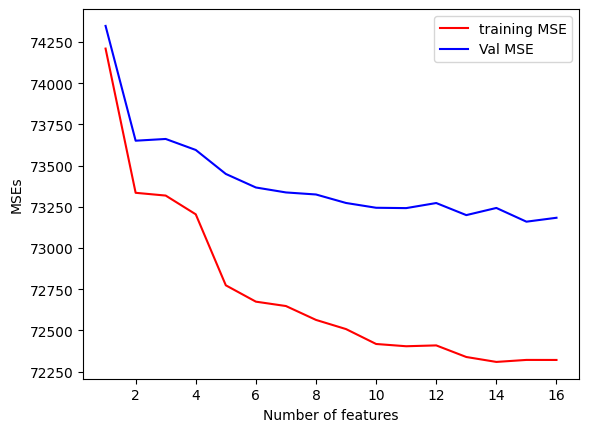

([74210.41299686748,
  73334.9663683313,
  73318.1748846885,
  73204.40434912863,
  72773.45204192682,
  72674.22132493432,
  72647.66613157986,
  72563.41089243043,
  72507.69075041245,
  72417.3185696675,
  72403.56850422283,
  72408.70669794528,
  72338.30296636828,
  72308.41844653696,
  72320.56521154006,
  72320.35272026843],
 [74347.9727866231,
  73651.22692697361,
  73661.79969456342,
  73595.02407391473,
  73449.47199931814,
  73367.2464500494,
  73337.21888949606,
  73324.76057559445,
  73273.20866534395,
  73244.17464661447,
  73242.04779929922,
  73272.88350891932,
  73199.55137765479,
  73243.02551918468,
  73159.7315911754,
  73183.47316947163])

In [ ]:
train_mse, val_mse = run_model(X, y, selected_features)

1 314.52002697969147
2 345.88559422205435
3 448.24407300339954
4 496.513947160769
5 624.1446211584262
6 649.906589281105
7 692.84833227341
8 769.9911211324943
9 842.9302209008601


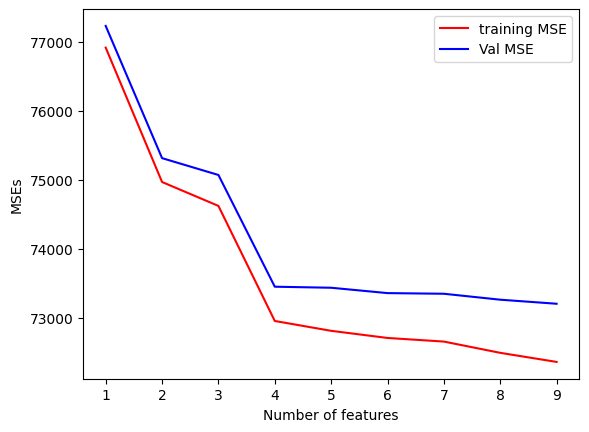

([76914.54261811309,
  74967.38637881033,
  74621.02161045211,
  72953.83134280921,
  72811.12806352013,
  72707.7162497543,
  72655.35962690448,
  72492.11304601327,
  72360.5233423938],
 [77229.06264509278,
  75313.27197303239,
  75069.26568345551,
  73450.34528996998,
  73435.27268467855,
  73357.62283903541,
  73348.20795917789,
  73262.10416714576,
  73203.45356329466])

In [ ]:
train_mse, val_mse = run_model(X, y, rfe_features)

1 137.15873089971137
2 296.1422061344638
3 389.552715020749
4 606.6931596654904
5 514.2090707110619
6 792.0472283648123
7 692.0635135393677
8 674.1576388915128
9 705.4773243710661
10 585.9494635615847
11 595.4773444782331


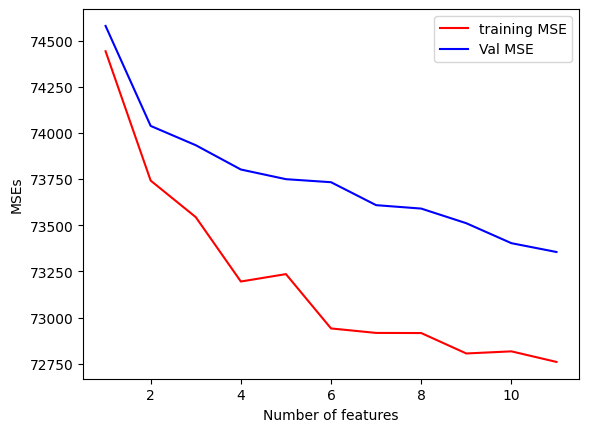

([74442.25722751697,
  73741.63378093406,
  73543.73513878304,
  73194.96338091705,
  73235.07588692587,
  72940.80655849686,
  72916.51147835443,
  72915.85266833394,
  72805.23024732326,
  72816.65498432309,
  72759.41689969279],
 [74579.41595841668,
  74037.77598706853,
  73933.28785380379,
  73801.65654058254,
  73749.28495763693,
  73732.85378686167,
  73608.5749918938,
  73590.01030722546,
  73510.70757169432,
  73402.60444788467,
  73354.89424417102])

In [ ]:
train_mse, val_mse = run_model(X, y, mi_features[:12])

## Training

In [ ]:
# From MI score
#X_train = X[mi_features[:9]]
#X_train = X[rfe_features[:9]]
X_train = X[selected_features[:5]]

# From RFE
#x = X[selected_features]
X_train.shape

(188533, 5)

In [ ]:
# Split dataset into training, validation and testing subsets
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y, test_size=0.3, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape)

(131973, 5) (131973,)


In [ ]:
required_features = X_train.columns
required_features

Index(['mil/hp', 'AverageMilage', 'brand', 'milage', 'l/cyl'], dtype='object')

In [ ]:
continuos_features_to_scale = [col for col in X_train.columns if col not in new_categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

scalerTrain = StandardScaler()
x_train = scalerTrain.fit_transform(X_train[continuos_features_to_scale])
x_cv = scalerTrain.transform(X_cv[continuos_features_to_scale])

Features to be scaled: ['mil/hp', 'AverageMilage', 'milage', 'l/cyl']


In [ ]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
ypred = model.predict(x_train)
xgb_train_mse = mean_squared_error(y_train, ypred)
np.sqrt(xgb_train_mse)

72790.79638009223

In [ ]:
get_error(model, x_train, x_cv, y_train, y_cv)

train MSE: 72790.79638009223
Validation MSE: 73436.92122043688
Difference: 646.1248


In [ ]:
'''xgb_model = XGBRegressor(
n_estimators=200,
max_depth=3,
learning_rate=0.01,
)

xgb_model.fit(x_train_mapped, y_train)'''

'xgb_model = XGBRegressor(\nn_estimators=200,\nmax_depth=3,\nlearning_rate=0.01,\n)\n\nxgb_model.fit(x_train_mapped, y_train)'

### Submission

In [ ]:
test = pd.read_csv('test.csv')
id = test.pop('id')

In [ ]:
test = df_missing_cat(test)
test = create_features(test)
test = df_missing_new_cat(test, new_categoricals)
test = df_missing_cont(test, new_categoricals)
test = create_interactions(test)
test['AverageMilage'] = test.groupby("brand")['milage'].transform('mean')
test['BrandFreq'] = test.groupby('brand')['brand'].transform('count')/test['brand'].count()
test = df_missing_cont(test, new_categoricals)

categorical attributes: ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Missing categories: ['fuel_type', 'accident', 'clean_title']
Categorical missing features: ['L', 'cylinders', 'gears']
Missing continuos features: ['hp', 'valves']
Missing continuos features: ['mil/year']


In [ ]:
for colname in new_categoricals:
    test[colname], _ = test[colname].factorize()

In [ ]:
test_scaled = scaler_pca.transform(test)
pca_components = pca.transform(test)
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Explained Variance Ratio:", explained_variance)
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
test = pd.concat([test, pca_df], axis=1)

Explained Variance Ratio: 0.3265216923547145


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [ ]:
x_test = test[selected_features[:5]]
continuos_features_to_scale = [col for col in x_test.columns if col not in new_categoricals]
print(f'Features to be scaled: {continuos_features_to_scale}')

x_test = scalerTrain.transform(x_test[continuos_features_to_scale])

Features to be scaled: ['mil/hp', 'AverageMilage', 'milage', 'l/cyl']


In [ ]:
pred = model.predict(x_test)

In [ ]:
submision = pd.DataFrame({'id': id, 'price': pred})
submision.to_csv('submission.csv', index=False)

In [ ]:
submision.head()

,id,price
0,188533,18706.699219
1,188534,79769.632812
2,188535,54196.515625
3,188536,33545.480469
4,188537,29071.917969
